# Construisez un modèle de scoring

## Introduction

<div>
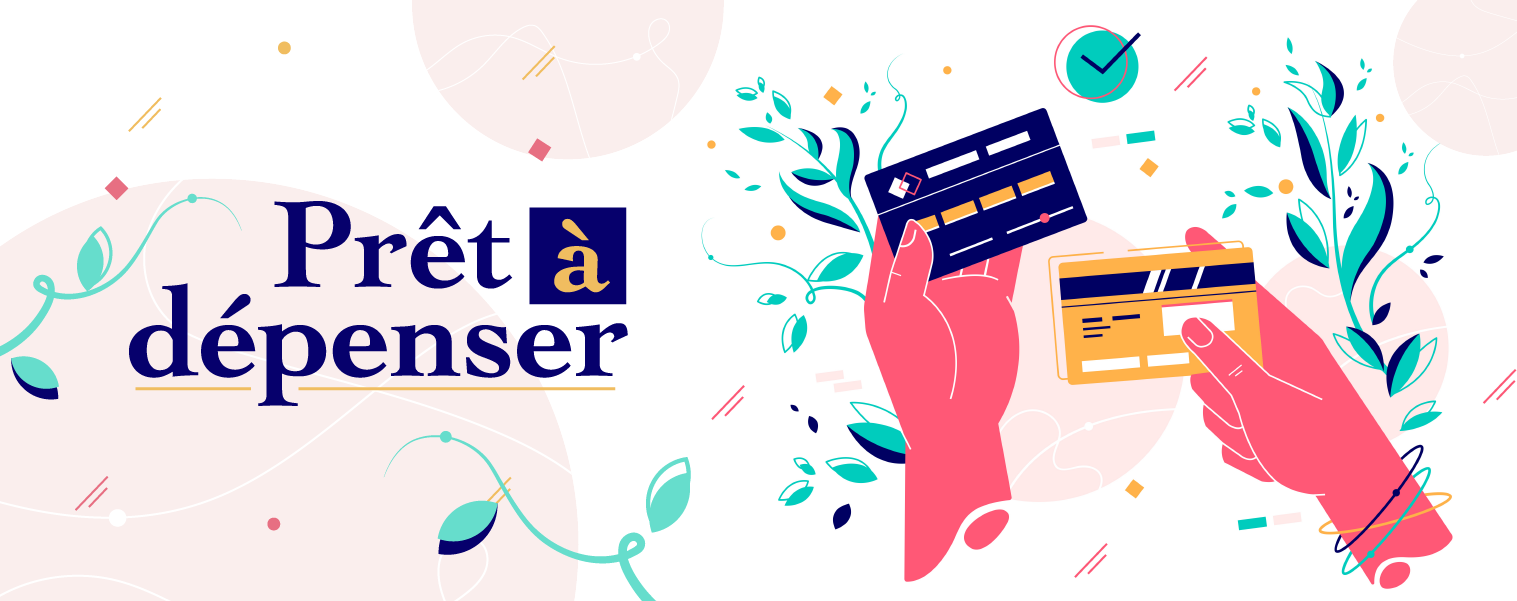
</div>

**Mon rôle:** Data Scientist  
**Nom de la société**: Prêt à dépenser  
**Service de la société**: Propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.

**Mission**: Aider à décider si un prêt peut être accordé à un client.  
Mettre en œuvre un algorithme de classification de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non.  
Puis classifie la demande : crédit accordé ou refusé.

**Utilisateurs**: Chargés de relation client.

**Remarques**: Le modèle doit être facilement interprétable et doit disposer d’une mesure de l’importance des variables pour définir la probabilité.

---

**Fichiers d'entrée**:
- [10 fichiers CSV](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)
- [Explication de chaque fichier](https://www.kaggle.com/c/home-credit-default-risk/data)
- Description des colonnes: Voir le fichier: [HomeCredit_columns_description.csv](../input/HomeCredit_columns_description.csv)

## Importation des différents fichiers

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

Regardons nos fichiers disponibles:

In [2]:
os.listdir("../input/")

['application_test.csv',
 '.DS_Store',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 '.ipynb_checkpoints',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

**Description des différents fichiers ici:**
- [Description des fichiers](link)
- [Description de chaque colonne](./../input/HomeCredit_columns_description.csv)

On va se concentrer sur 2 fichiers qui contiennent le plus de données pour commencer:
- application_test.csv
- application_train.csv

On remarque que le fichier application_train est le seul à avoir la colonne TARGET.
Quand la valeur = 1, le client a eu des difficultés de paiement.
Quand la valeur = 0, le client n'a pas eu de difficulté.

C'est ce qu'on va chercher à prédire dans les 2 fichiers.

In [3]:
# Load the 2 files
app_train = pd.read_csv('../input/application_train.csv')
app_test = pd.read_csv('../input/application_test.csv')
print('On observe les lignes et colonnes: ', app_train.shape)

On observe les lignes et colonnes:  (307511, 122)


Parmis les colonnes existantes, je préfère retirer toute colonnes qui ne sont pas éthiques pour éviter de potentiel bias dans les résultats.

In [4]:
# Removing unethical columns to remove bias
unethical_columns = [
    "CODE_GENDER", # Gender of the client
    "DAYS_BIRTH", # Client's age in days at the time of application
]

# Dropping unethical columns
app_train.drop(columns=unethical_columns, inplace=True)
app_test.drop(columns=unethical_columns, inplace=True)

app_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100002       1         Cash loans            N               Y   
1      100003       0         Cash loans            N               N   
2      100004       0    Revolving loans            Y               Y   
3      100006       0         Cash loans            N               Y   
4      100007       0         Cash loans            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        NaN                        NaN   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 120 columns]

J'observe les types de mes différentes variables.

In [5]:
app_train.dtypes.value_counts()

float64    65
int64      40
object     15
Name: count, dtype: int64

Je remarque que j'ai 15 colonnes de type object, je vais surement devoir les encoder en fonction du nombre de valeurs unique.  
Je vais déjà stocker les colonnes de chaque type dans des variables différentes.

In [6]:
col_type_int64 = app_train.select_dtypes('int64').columns
col_type_float64 = app_train.select_dtypes('float64').columns
col_type_object = app_train.select_dtypes('object').columns

J'affiche les valeurs manquantes pour chaque type.

### Inspection du type Int64

In [7]:
def create_percentage_missing_chart(df, xticksRange):
    # Get the missing data in percentage
    missing_data = df.isna().mean() * 100

    # Sort by value asc
    missing_data = missing_data.sort_values()

    # Create the figure
    plt.figure(figsize=(12, 2))

    ## Add horizontal lines
    sns.set_style('whitegrid')

    ## Set a color palette (https://seaborn.pydata.org/tutorial/color_palettes.html)
    colors = sns.color_palette("rocket_r", len(missing_data))

    ## Create the barplot
    sns.barplot(x=missing_data.index, y=missing_data,  palette=colors) # Create the bar plot

    ## Rotate the x labels and only one out of three for better readability
    plt.xticks(rotation=-90)
    plt.xticks(range(0, len(missing_data.index), xticksRange))

    ## Set the labels
    plt.ylabel('Pourcentage')
    plt.xlabel('Colonnes')
    plt.title('Pourcentage de valeurs manquantes')
    plt.show()

def create_color_palette(values, thresholds, colors):  
    """Create a color palette based on the given thresholds and colors."""  
    color_palette = []  
    for value in values:  
        for i in range(len(thresholds)):  
            if value < thresholds[i]:  
                color_palette.append(colors[i])  
                break  
        else:  
            color_palette.append(colors[-1])  
    return color_palette

def display_graph_missing_data(df, figsize_height):
    # Calculate the missing value percentage and count for each column  
    missing_data = df.isna().mean() * 100  
    missing_count = df.isna().sum()  
    unique_count = df.nunique()
    # Create a DataFrame to store the missing value percentage and count  
    missing_df = pd.DataFrame({"Missing Percentage": missing_data, "Missing Count": missing_count, "Unique Count": unique_count})  

    # Sort the DataFrame by missing percentage in descending order  
    missing_df = missing_df.sort_values(by="Missing Percentage", ascending=False)  
    thresholds = [25, 50, 75, 100]  
    colors = ["#4fff87", "#4fc4ff", "#ffbc4f", "#ff4f4f"]  

    # Map the colors based on the percentage value  

    color_palette = create_color_palette(missing_df["Missing Percentage"], thresholds, colors)  

    plt.figure(figsize=(10, figsize_height)) # Adjust the figure size as per your preference  
    ax = sns.barplot(x="Missing Percentage", y=missing_df.index, data=missing_df, palette=color_palette) # Create a horizontal bar plot  

    # Add labels and legend to the plot  
    plt.xlabel("Valeurs manquantes en %")  
    plt.ylabel("Colonnes")  
    plt.title("Pourcentage de valeurs manquantes")  

    # Add the count of missing values inside each bar  
    # for i, (value, name) in enumerate(zip(missing_df["Missing Count"], missing_df.index)):  
    #     ax.text(1, i, f" {value} ", va="center")  
    for i, (missing_value, unique_value, name) in enumerate(  
        zip(missing_df["Missing Count"], missing_df["Unique Count"], missing_df.index)  
    ):
        ax.text(1, i, f"Manquant: {missing_value}", va="center")
        ax.text(20, i, f"Unique: {unique_value}", va="center")
    # Create a custom legend  
    legend_labels = [f"{thresholds[i]-25}-{thresholds[i+1]-25}%" if i != len(thresholds)-1 else f"{thresholds[i]-25}+%" for i in range(len(thresholds))]  
    colors_scaled = [plt.cm.colors.to_rgb(color) for color in colors]  
    legend_elements = [plt.Line2D([0], [0], marker="s", color="white", markerfacecolor=colors_scaled[i], markersize=10) for i in range(len(colors))]  
    plt.legend(legend_elements, legend_labels, loc="lower right")
    
    # Display the plot  
    plt.show()

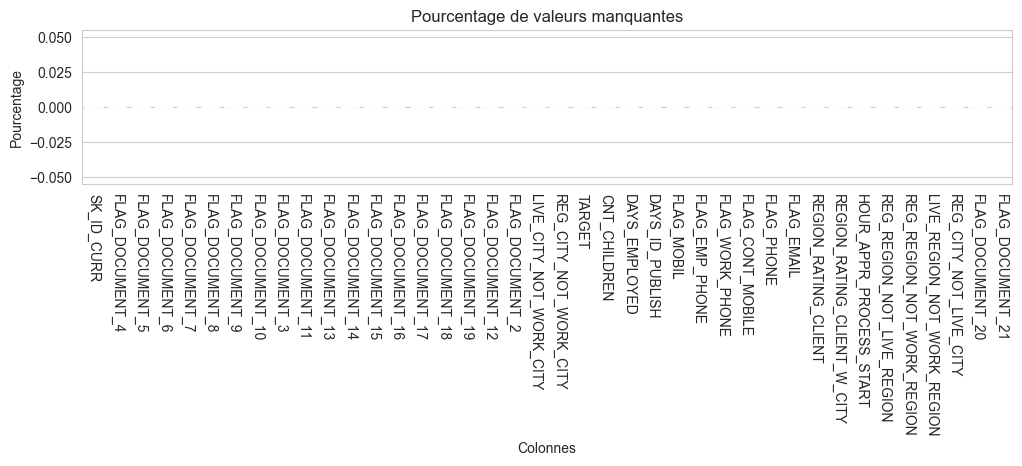

In [8]:
create_percentage_missing_chart(app_train[col_type_int64], 1)

In [9]:
app_train.shape

(307511, 120)

In [10]:
# Checking outliers for int64
pd.set_option("display.max_columns", None)
app_train[col_type_int64].describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  DAYS_EMPLOYED  \
count  307511.000000  307511.000000  307511.000000  307511.000000   
mean   278180.518577       0.080729       0.417052   63815.045904   
std    102790.175348       0.272419       0.722121  141275.766519   
min    100002.000000       0.000000       0.000000  -17912.000000   
25%    189145.500000       0.000000       0.000000   -2760.000000   
50%    278202.000000       0.000000       0.000000   -1213.000000   
75%    367142.500000       0.000000       1.000000    -289.000000   
max    456255.000000       1.000000      19.000000  365243.000000   

       DAYS_ID_PUBLISH     FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
count    307511.000000  307511.000000   307511.000000    307511.000000   
mean      -2994.202373       0.999997        0.819889         0.199368   
std        1509.450419       0.001803        0.384280         0.399526   
min       -7197.000000       0.000000        0.000000         0.000000   
25%       -4299.000000       1.000000        1.000000         0.000000   
50%       -3254.000000       1.000000        1.000000         0.000000   
75%       -1720.000000       1.000000        1.000000         0.000000   
max           0.000000       1.000000        1.000000         1.000000   

       FLAG_CONT_MOBILE     FLAG_PHONE     FLAG_EMAIL  REGION_RATING_CLIENT  \
count     307511.000000  307511.000000  307511.000000         307511.000000   
mean           0.998133       0.281066       0.056720              2.052463   
std            0.043164       0.449521       0.231307              0.509034   
min            0.000000       0.000000       0.000000              1.000000   
25%            1.000000       0.000000       0.000000              2.000000   
50%            1.000000       0.000000       0.000000              2.000000   
75%            1.000000       1.000000       0.000000              2.000000   
max            1.000000       1.000000       1.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                307511.000000            307511.000000   
mean                      2.031521                12.063419   
std                       0.502737                 3.265832   
min                       1.000000                 0.000000   
25%                       2.000000                10.000000   
50%                       2.000000                12.000000   
75%                       2.000000                14.000000   
max                       3.000000                23.000000   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
count               307511.000000               307511.000000   
mean                     0.015144                    0.050769   
std                      0.122126                    0.219526   
min                      0.000000                    0.000000   
25%                      0.000000                    0.000000   
50%                      0.000000                    0.000000   
75%                      0.000000                    0.000000   
max                      1.000000                    1.000000   

       LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
count                307511.000000           307511.000000   
mean                      0.040659                0.078173   
std                       0.197499                0.268444   
min                       0.000000                0.000000   
25%                       0.000000                0.000000   
50%                       0.000000                0.000000   
75%                       0.000000                0.000000   
max                       1.000000                1.000000   

       REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  FLAG_DOCUMENT_2  \
count           307511.000000            307511.000000    307511.000000   
mean                 0.230454                 0.179555         0.000042   
std                  0.421124                 0.383817         0.006502

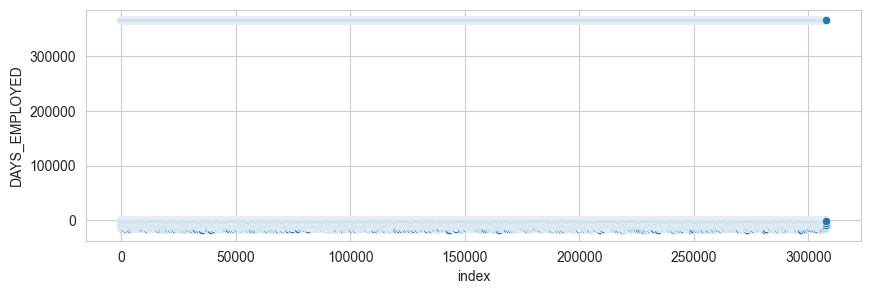

In [11]:
# Reset index for the dataframe
prds = app_train['DAYS_EMPLOYED'].copy().reset_index()  
# Create scatter plot using seaborn
plt.figure(figsize=(10, 3))
sns.scatterplot(data=prds,x='index', y='DAYS_EMPLOYED')

# Show the plot
plt.show()

In [86]:
# app_train[app_train['DAYS_EMPLOYED'] >= 0]['DAYS_EMPLOYED'].value_counts()
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243 # Is employed ?
app_train['DAYS_EMPLOYED'].replace({365243: np.NaN}, inplace = True) # TODO (You can normalize those data, is has to be positive)
# You can use DAYS_EMPLOYED if you "normalize" it to not modify the weight (test with 1 instead of 0)
# Keep the data in positive and 365243 to -1

In [87]:
app_train['DAYS_EMPLOYED'].isna().sum()

55374

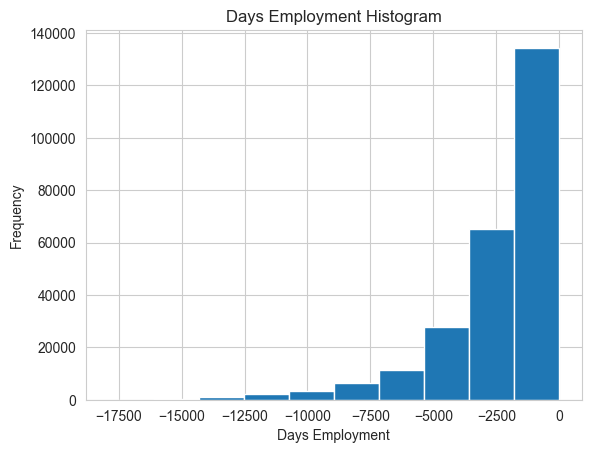

In [13]:
# Days employed 
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

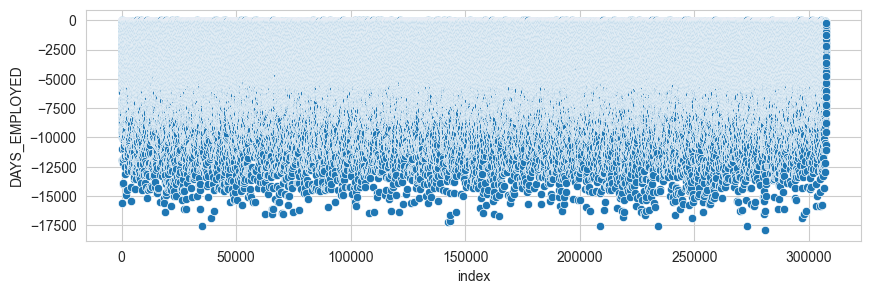

In [14]:
# Reset index for the dataframe
prds = app_train['DAYS_EMPLOYED'].copy().reset_index()  
# Create scatter plot using seaborn
plt.figure(figsize=(10, 3))
sns.scatterplot(data=prds,x='index', y='DAYS_EMPLOYED')

# Show the plot
plt.show()

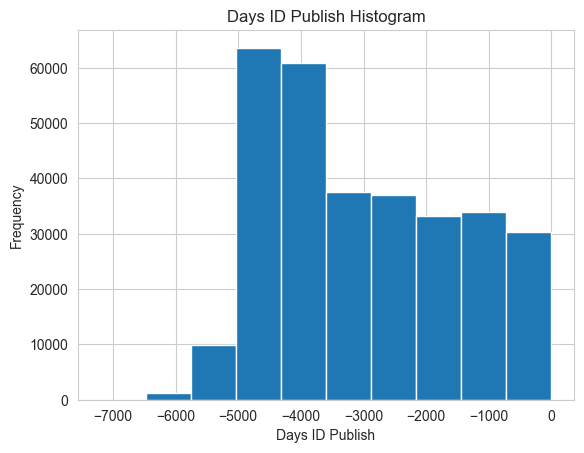

In [15]:
# Days ID publish 
app_train['DAYS_ID_PUBLISH'].plot.hist(title = 'Days ID Publish Histogram');
plt.xlabel('Days ID Publish');

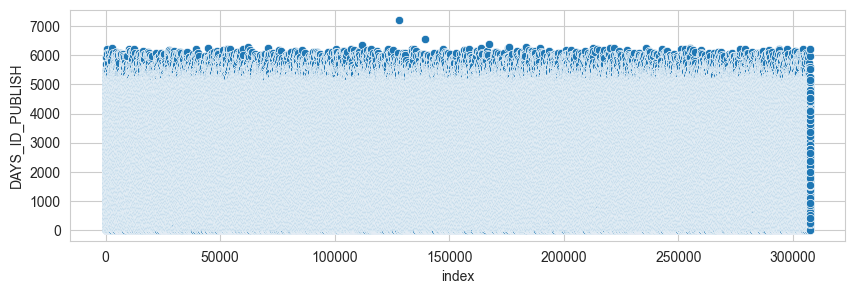

In [16]:
app_train['DAYS_ID_PUBLISH'] = abs(app_train['DAYS_ID_PUBLISH']) # Todo check bias
# Reset index for the dataframe
prds = app_train['DAYS_ID_PUBLISH'].copy().reset_index()  
# Create scatter plot using seaborn
plt.figure(figsize=(10, 3))
sns.scatterplot(data=prds,x='index', y='DAYS_ID_PUBLISH')

# Show the plot  
plt.show()

### Inspection du type Float64

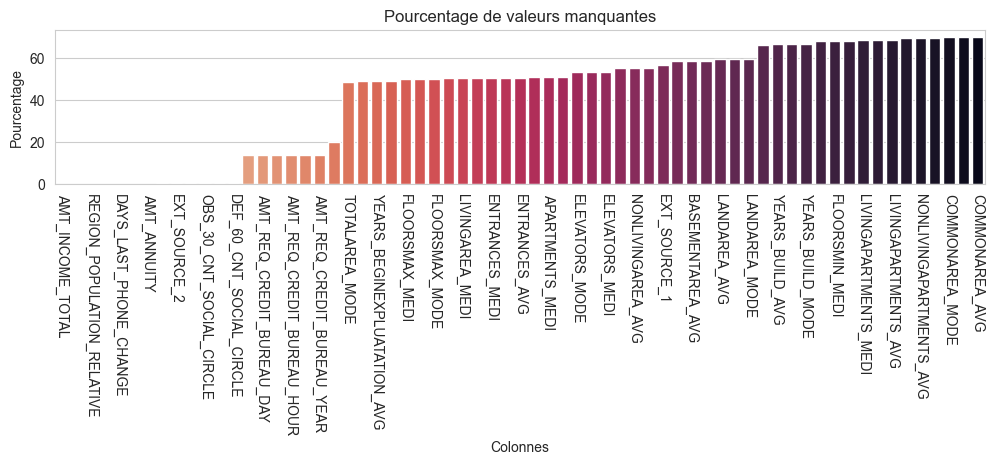

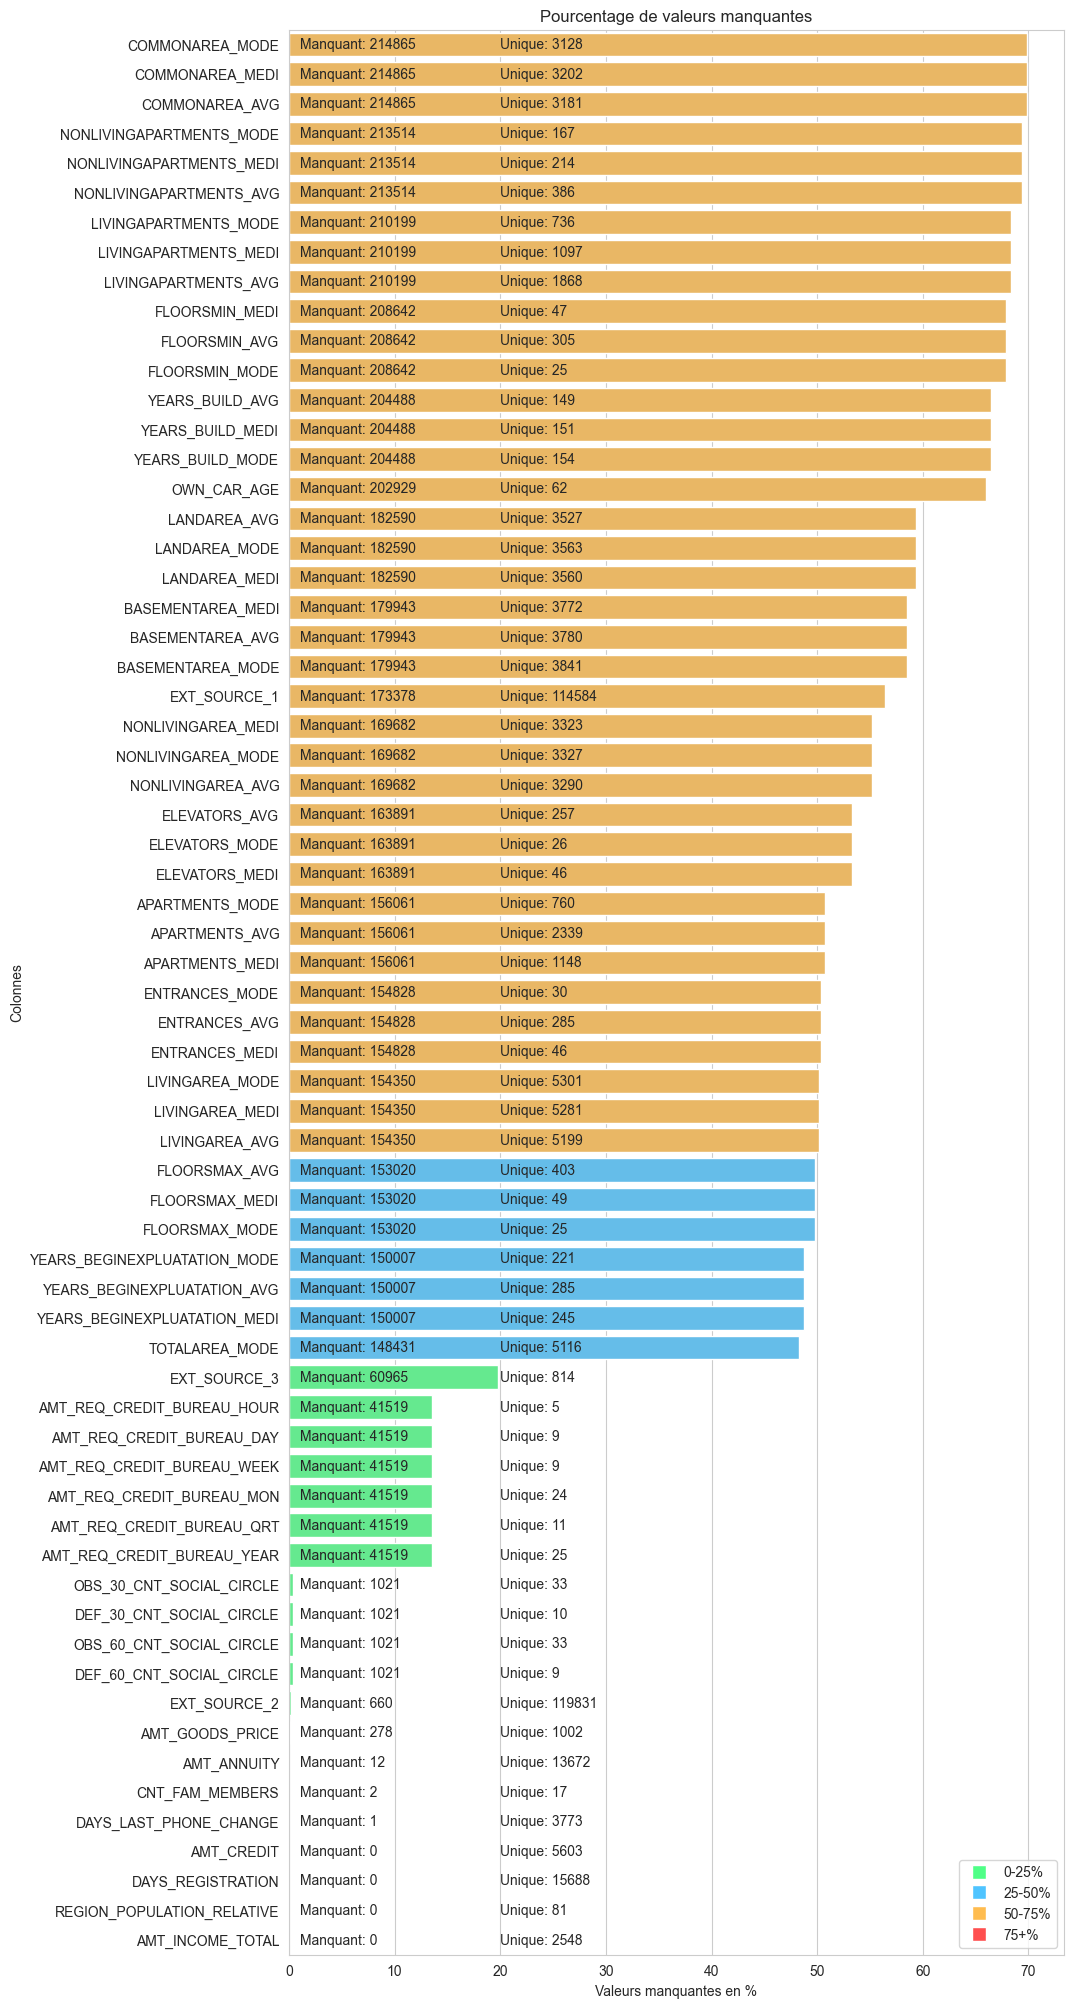

In [17]:
create_percentage_missing_chart(app_train[col_type_float64], 2)
display_graph_missing_data(app_train[col_type_float64], 25)

In [18]:
app_train[col_type_float64].describe()

AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count      3.075110e+05  3.075110e+05  307499.000000     3.072330e+05   
mean       1.687979e+05  5.990260e+05   27108.573909     5.383962e+05   
std        2.371231e+05  4.024908e+05   14493.737315     3.694465e+05   
min        2.565000e+04  4.500000e+04    1615.500000     4.050000e+04   
25%        1.125000e+05  2.700000e+05   16524.000000     2.385000e+05   
50%        1.471500e+05  5.135310e+05   24903.000000     4.500000e+05   
75%        2.025000e+05  8.086500e+05   34596.000000     6.795000e+05   
max        1.170000e+08  4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE  DAYS_REGISTRATION    OWN_CAR_AGE  \
count               307511.000000      307511.000000  104582.000000   
mean                     0.020868       -4986.120328      12.061091   
std                      0.013831        3522.886321      11.944812   
min                      0.000290      -24672.000000       0.000000   
25%                      0.010006       -7479.500000       5.000000   
50%                      0.018850       -4504.000000       9.000000   
75%                      0.028663       -2010.000000      15.000000   
max                      0.072508           0.000000      91.000000   

       CNT_FAM_MEMBERS   EXT_SOURCE_1  EXT_SOURCE_2   EXT_SOURCE_3  \
count    307509.000000  134133.000000  3.068510e+05  246546.000000   
mean          2.152665       0.502130  5.143927e-01       0.510853   
std           0.910682       0.211062  1.910602e-01       0.194844   
min           1.000000       0.014568  8.173617e-08       0.000527   
25%           2.000000       0.334007  3.924574e-01       0.370650   
50%           2.000000       0.505998  5.659614e-01       0.535276   
75%           3.000000       0.675053  6.636171e-01       0.669057   
max          20.000000       0.962693  8.549997e-01       0.896010   

       APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
count    151450.00000     127568.000000                157504.000000   
mean          0.11744          0.088442                     0.977735   
std           0.10824          0.082438                     0.059223   
min           0.00000          0.000000                     0.000000   
25%           0.05770          0.044200                     0.976700   
50%           0.08760          0.076300                     0.981600   
75%           0.14850          0.112200                     0.986600   
max           1.00000          1.000000                     1.000000   

       YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  \
count    103023.000000    92646.000000  143620.000000  152683.000000   
mean          0.752471        0.044621       0.078942       0.149725   
std           0.113280        0.076036       0.134576       0.100049   
min           0.000000        0.000000       0.000000       0.000000   
25%           0.687200        0.007800       0.000000       0.069000   
50%           0.755200        0.021100       0.000000       0.137900   
75%           0.823200        0.051500       0.120000       0.206900   
max           1.000000        1.000000       1.000000       1.000000   

       FLOORSMAX_AVG  FLOORSMIN_AVG   LANDAREA_AVG  LIVINGAPARTMENTS_AVG  \
count  154491.000000   98869.000000  124921.000000          97312.000000   
mean        0.226282       0.231894       0.066333              0.100775   
std         0.144641       0.161380       0.081184              0.092576   
min         0.000000       0.000000       0.000000              0.000000   
25%         0.166700       0.083300       0.018700              0.050400   
50%         0.166700       0.208300       0.048100              0.075600   
75%         0.333300       0.375000       0.085600              0.121000   
max         1.000000       1.000000       1.000000              1.000000   

       LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  \
count   153161.000000     

In [19]:
app_train["AMT_ANNUITY"].value_counts()

AMT_ANNUITY
9000.0      6385
13500.0     5514
6750.0      2279
10125.0     2035
37800.0     1602
            ... 
79902.0        1
106969.5       1
60885.0        1
59661.0        1
77809.5        1
Name: count, Length: 13672, dtype: int64

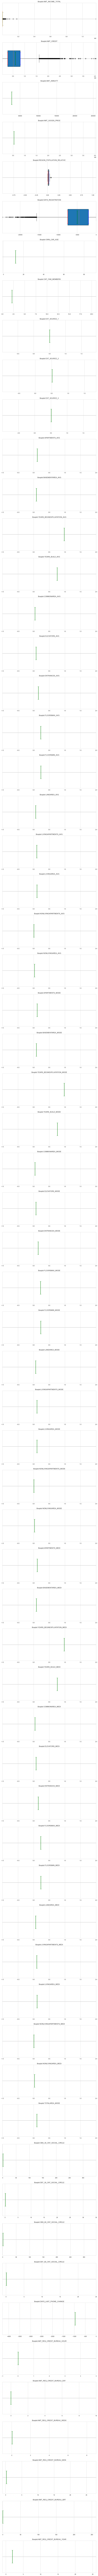

In [20]:


# Combine the data into a list
data = [app_train[col] for col in col_type_float64]

# Set up the figure and axes
fig, axs = plt.subplots(nrows=len(data), ncols=1, figsize=(10, 4*len(data)), sharey=True)

# Plot horizontal boxplots for each dataset
for i, ax in enumerate(axs):
    ax.boxplot(data[i], vert=False, widths=0.5, patch_artist=True)
    ax.set_title(f'Boxplot {col_type_float64[i]}')
    ax.set_yticklabels([])  # Hide y-axis labels

    # Display Q1, Q3, and mean
    q1 = np.percentile(data[i], 25)
    q3 = np.percentile(data[i], 75)
    mean = np.mean(data[i])
    
    # ax.set_xticks([min(data[i]), q1, mean, q3, max(data[i])])
    # ax.set_xticklabels([min(data[i]), q1, mean, q3, max(data[i])])

    # ax.set_xticklabels(['Min', 'Q1', 'Mean', 'Q3', 'Max'])
    
    ax.plot([q1, q1], [0.8, 1.2], color='red', linewidth=2, marker='_', markersize=10, label='Q1')
    ax.plot([q3, q3], [0.8, 1.2], color='blue', linewidth=2, marker='_', markersize=10, label='Q3')
    ax.plot([mean, mean], [0.8, 1.2], color='green', linewidth=2, marker='_', markersize=10, label='Mean')

    ax.set_xlim(np.nanmin(data[i]) - 1, np.nanmax(data[i]) + 1)

plt.tight_layout()

# Adjust layout
plt.show()

Je décide de supprimer les incomes > 500k pour retirer les outliers

In [21]:
# Suppression 
app_train.drop(app_train[app_train["AMT_INCOME_TOTAL"] >= 500000.0].index, inplace=True) # TODO just for the graph
app_train.shape

(304809, 120)

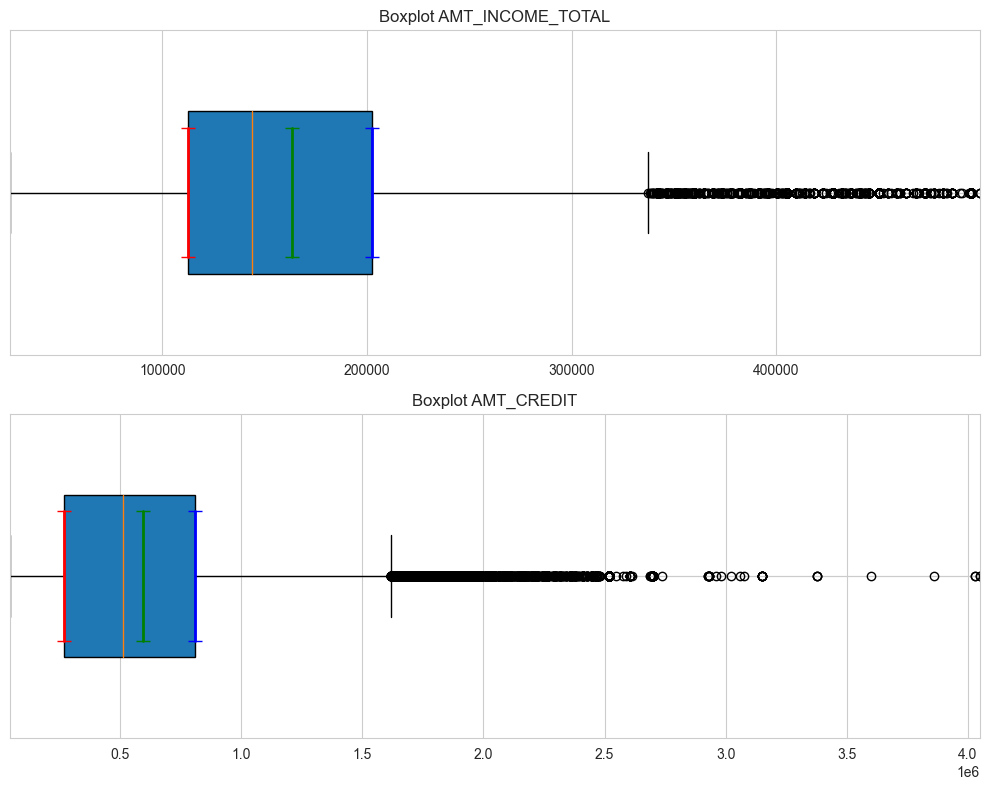

In [22]:


# Combine the data into a list
data = [app_train["AMT_INCOME_TOTAL"],app_train["AMT_CREDIT"]]

# Set up the figure and axes
fig, axs = plt.subplots(nrows=len(data), ncols=1, figsize=(10, 4*len(data)), sharey=True)

# Plot horizontal boxplots for each dataset
for i, ax in enumerate(axs):
    ax.boxplot(data[i], vert=False, widths=0.5, patch_artist=True)
    ax.set_title(f'Boxplot {col_type_float64[i]}')
    ax.set_yticklabels([])  # Hide y-axis labels

    # Display Q1, Q3, and mean
    q1 = np.percentile(data[i], 25)
    q3 = np.percentile(data[i], 75)
    mean = np.mean(data[i])
    
    # ax.set_xticks([min(data[i]), q1, mean, q3, max(data[i])])
    # ax.set_xticklabels([min(data[i]), q1, mean, q3, max(data[i])])

    # ax.set_xticklabels(['Min', 'Q1', 'Mean', 'Q3', 'Max'])
    
    ax.plot([q1, q1], [0.8, 1.2], color='red', linewidth=2, marker='_', markersize=10, label='Q1')
    ax.plot([q3, q3], [0.8, 1.2], color='blue', linewidth=2, marker='_', markersize=10, label='Q3')
    ax.plot([mean, mean], [0.8, 1.2], color='green', linewidth=2, marker='_', markersize=10, label='Mean')

    ax.set_xlim(np.nanmin(data[i]) - 1, np.nanmax(data[i]) + 1)

plt.tight_layout()

# Adjust layout
plt.show()

### Inspection du type Object

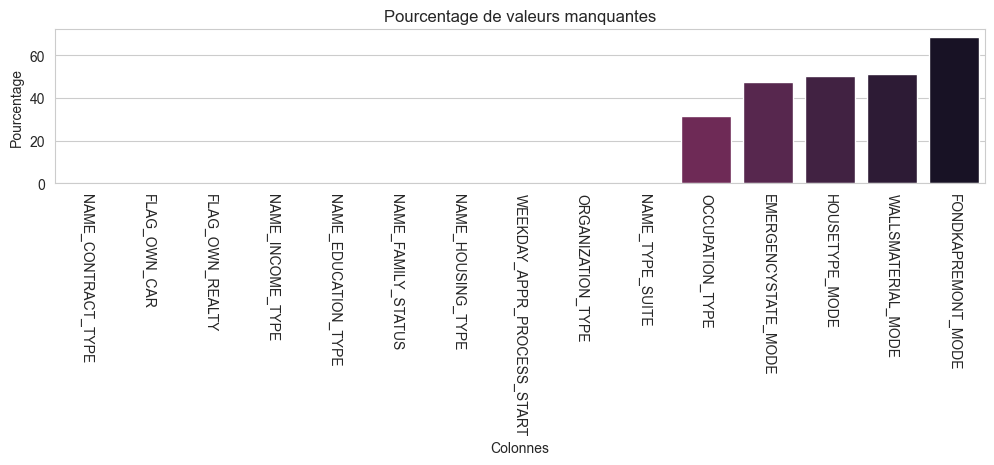

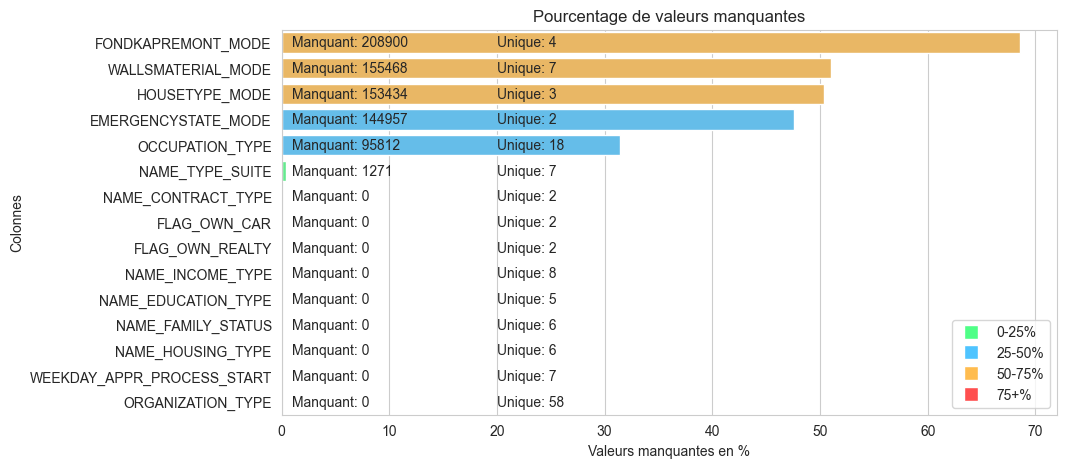

In [23]:
create_percentage_missing_chart(app_train[col_type_object], 1)
display_graph_missing_data(app_train[col_type_object], 5)

In [24]:
# Label encode object (<= unique type > Label encoder
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # print(
        unique_vals = list(app_train[col].unique())
                 
        if len(unique_vals) <= 2.0:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col].map(lambda x: x if x in unique_vals else np.nan))
            app_test[col] = le.transform(app_test[col].map(lambda x: x if x in unique_vals else 0))
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)


3 columns were label encoded.


In [25]:
# One-hot encoding for feature with > 2 unique values
print('Training Features shape before: ', app_train.shape)
print('Testing Features shape before: ', app_test.shape)

# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('\nTraining Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape before:  (304809, 120)
Testing Features shape before:  (48744, 120)

Training Features shape:  (304809, 239)
Testing Features shape:  (48744, 237)


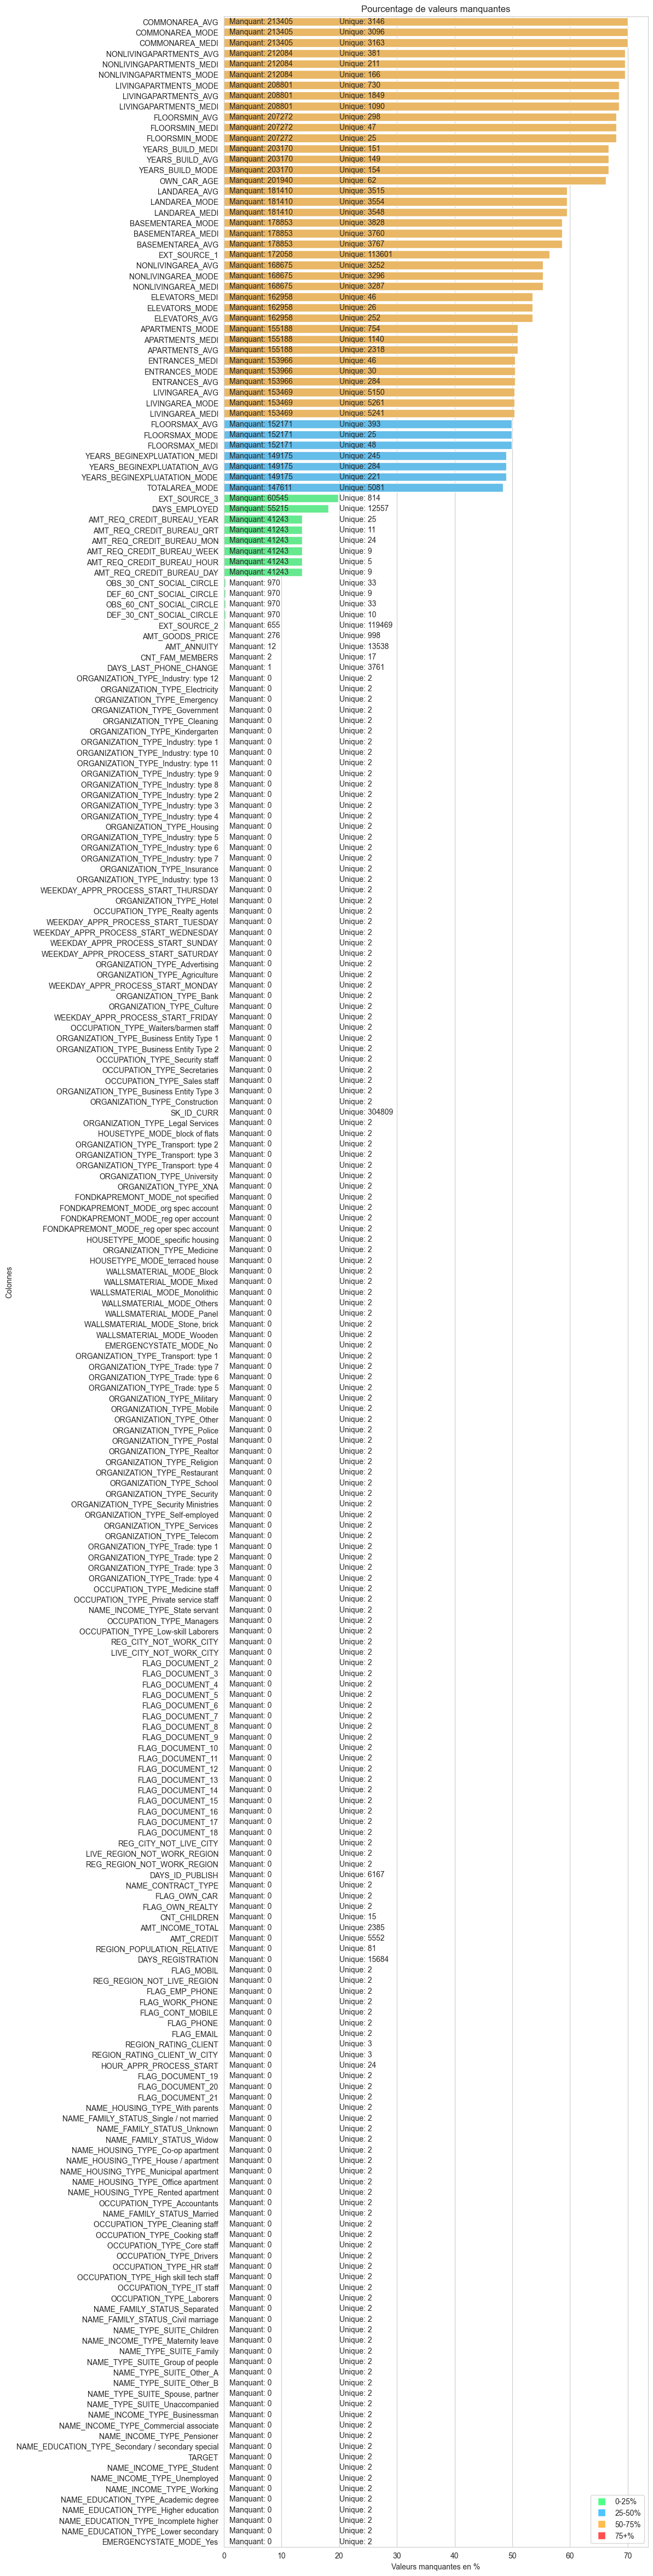

In [26]:
display_graph_missing_data(app_train, 60)

In [27]:
# Remove NAN HARD
clean_app_train = app_train.copy()
print(clean_app_train.shape)

clean_app_train.dropna(inplace=True)  
print(clean_app_train.shape)

(304809, 239)
(10420, 239)


In [28]:
X = clean_app_train.drop('TARGET', axis=1)  # Exclude the target column
y = clean_app_train['TARGET']

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(10420, 238)
(10420,)


In [ ]:
# Todo 
# Every data that you want to keep, modify it to positive
# Every data thagt you don't to delete, modify to -1
# Todo 2 > Instead of -1, put to 0 to check the weight

In [29]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [30]:
# Draw the feature importance
feature_importances = rf_model.feature_importances_
# Assuming feature_importances is a list or array containing feature importances
threshold = 0.01  # Set threshold

# Filter features based on the threshold
selected_features = [feature for feature, importance in zip(X.columns, feature_importances) if importance > threshold]

# Create a new feature matrix with selected features
X_selected = X[selected_features]

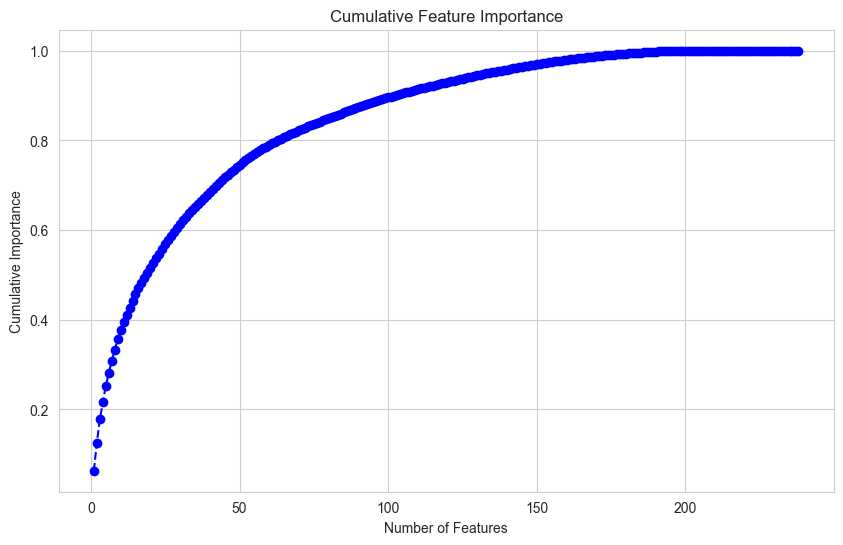

In [31]:
# list or array containing feature importances
feature_importances = rf_model.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_idx]

# Calculate cumulative importance
cumulative_importance = np.cumsum(sorted_importances)

# Plot the cumulative importance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.grid(True)
plt.show()
# TODO Table with score next to each columns (AGE & Gender)

In [32]:
selected_features

['SK_ID_CURR',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'LANDAREA_AVG',
 'LIVINGAREA_AVG',
 'COMMONAREA_MODE',
 'LANDAREA_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAREA_MODE',
 'COMMONAREA_MEDI',
 'LANDAREA_MEDI',
 'TOTALAREA_MODE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [33]:
# Correlation V2 
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 LIVE_CITY_NOT_WORK_CITY                              0.032503
OWN_CAR_AGE                                          0.037192
DAYS_REGISTRATION                                    0.042295
OCCUPATION_TYPE_Laborers                             0.042818
FLAG_DOCUMENT_3                                      0.044059
REG_CITY_NOT_LIVE_CITY                               0.044715
FLAG_EMP_PHONE                                       0.046319
NAME_EDUCATION_TYPE_Secondary / secondary special    0.048798
REG_CITY_NOT_WORK_CITY                               0.051042
DAYS_LAST_PHONE_CHANGE                               0.055551
NAME_INCOME_TYPE_Working                             0.057250
REGION_RATING_CLIENT                                 0.058567
REGION_RATING_CLIENT_W_CITY                          0.060505
DAYS_EMPLOYED                                        0.075114
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [34]:
print(len(correlations[correlations > threshold]))
correlations[correlations > threshold]

35


ORGANIZATION_TYPE_Restaurant                         0.010307
NAME_EDUCATION_TYPE_Lower secondary                  0.011768
OCCUPATION_TYPE_Cooking staff                        0.012162
OCCUPATION_TYPE_Security staff                       0.014544
ORGANIZATION_TYPE_Transport: type 3                  0.017690
CNT_CHILDREN                                         0.019401
OCCUPATION_TYPE_Sales staff                          0.019474
AMT_REQ_CREDIT_BUREAU_YEAR                           0.019763
NAME_HOUSING_TYPE_Rented apartment                   0.019859
ORGANIZATION_TYPE_Construction                       0.019970
NAME_FAMILY_STATUS_Civil marriage                    0.022372
ORGANIZATION_TYPE_Business Entity Type 3             0.024299
NAME_FAMILY_STATUS_Single / not married              0.026453
OCCUPATION_TYPE_Low-skill Laborers                   0.027605
FLAG_WORK_PHONE                                      0.028696
ORGANIZATION_TYPE_Self-employed                      0.029219
NAME_HOU

In [91]:
correlations[correlations > threshold].sum()
# Why 1.12, shouldn't the sum be 1 ?
# Todo, understand this

2.335223286262912

In [ ]:
# Compare randomforwest table & correlation table

### TODO

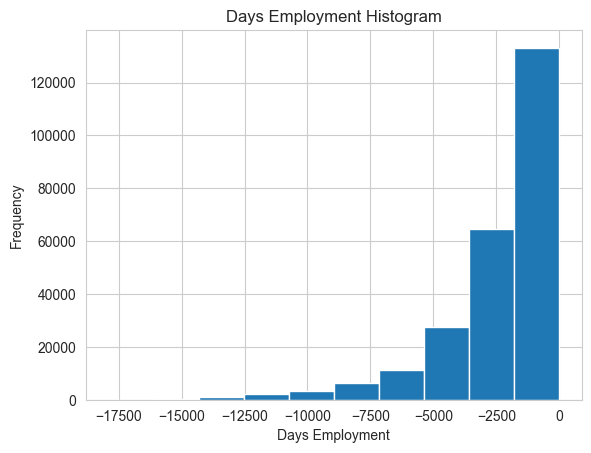

In [35]:
# Days employed 
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

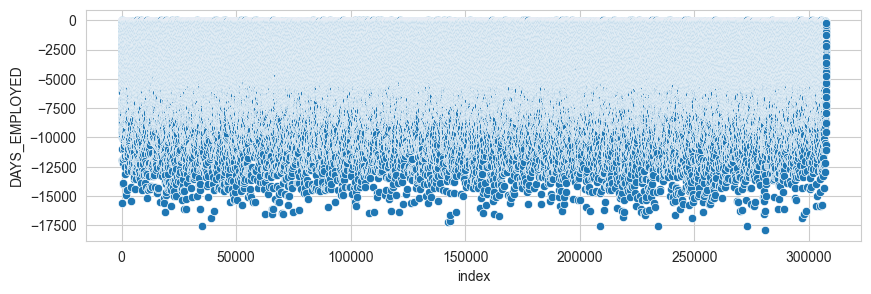

In [36]:
# Reset index for the dataframe
prds = app_train['DAYS_EMPLOYED'].copy().reset_index()  
# Create scatter plot using seaborn
plt.figure(figsize=(10, 3))
sns.scatterplot(data=prds,x='index', y='DAYS_EMPLOYED')

# Show the plot
plt.show()

In [37]:
app_train[app_train['DAYS_EMPLOYED'] >= 0]['DAYS_EMPLOYED'].value_counts()
app_train['DAYS_EMPLOYED'].replace({365243: 0}, inplace = True)

In [38]:
len(app_train[app_train['DAYS_EMPLOYED'] < 0])
# app_train['DAYS_EMPLOYED'] = abs(app_train['DAYS_EMPLOYED'])

249592

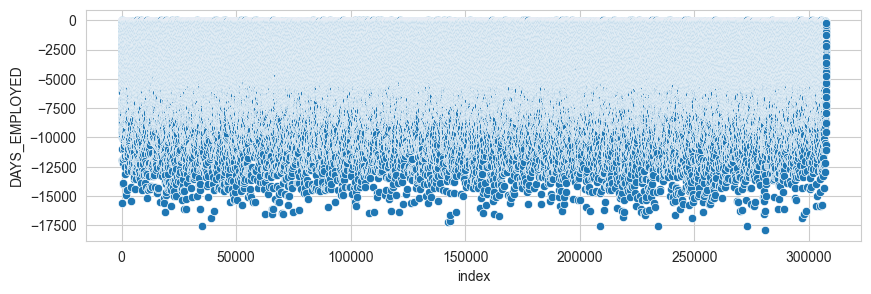

In [39]:
# Reset index for the dataframe
prds = app_train['DAYS_EMPLOYED'].copy().reset_index()  
# Create scatter plot using seaborn
plt.figure(figsize=(10, 3))
sns.scatterplot(data=prds,x='index', y='DAYS_EMPLOYED')

# Show the plot
plt.show()

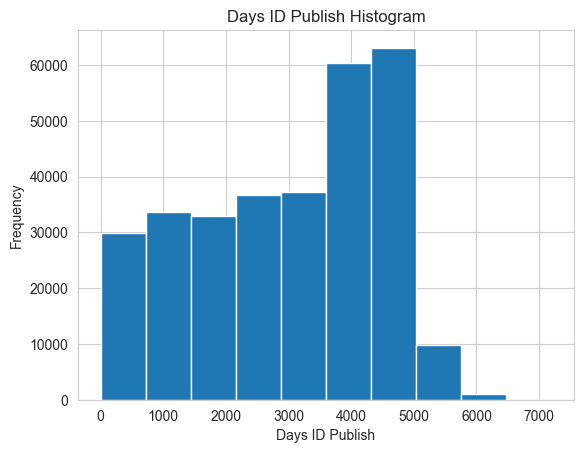

In [40]:
# Days ID publish 
app_train['DAYS_ID_PUBLISH'].plot.hist(title = 'Days ID Publish Histogram');
plt.xlabel('Days ID Publish');

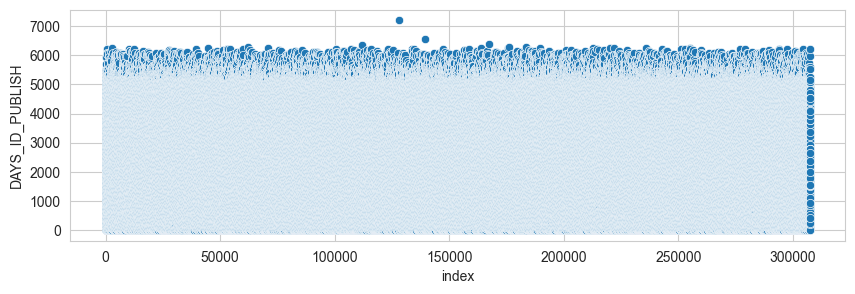

In [41]:
app_train['DAYS_ID_PUBLISH'] = abs(app_train['DAYS_ID_PUBLISH'])
# Reset index for the dataframe
prds = app_train['DAYS_ID_PUBLISH'].copy().reset_index()  
# Create scatter plot using seaborn
plt.figure(figsize=(10, 3))
sns.scatterplot(data=prds,x='index', y='DAYS_ID_PUBLISH')

# Show the plot  
plt.show()

In [42]:
# Encode categorical data

In [43]:
# Replace missing  value in object type (no need)

In [44]:
# Check outlier in all category (boxplot, awaiting)

In [45]:
# Try to replace missing value in int type ?
# You might just need to get the ome that have values

In [46]:
# No more missing value before continuing

In [47]:
# Check feature importance

# # Step 4: Build a Random Forest Model
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)

# # Step 5: Retrieve feature importances
# feature_importances = rf_model.feature_importances_

# # Display feature importances
# for feature, importance in zip(X.columns, feature_importances):
#     print(f"{feature}: {importance}")

In [48]:
# Create X and Y
# X = df.drop('target_column', axis=1)  # Exclude the target column
# y = df['target_column']

In [49]:
# Draw the feature importance

# # Assuming feature_importances is a list or array containing feature importances
# threshold = 0.01  # Set your threshold based on your analysis

# # Filter features based on the threshold
# selected_features = [feature for feature, importance in zip(X.columns, feature_importances) if importance > threshold]

# # Create a new feature matrix with selected features
# X_selected = X[selected_features]


# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming feature_importances is a list or array containing feature importances
# feature_importances = rf_model.feature_importances_

# # Sort features by importance
# sorted_idx = np.argsort(feature_importances)[::-1]
# sorted_importances = feature_importances[sorted_idx]

# # Calculate cumulative importance
# cumulative_importance = np.cumsum(sorted_importances)

# # Plot the cumulative importance
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', linestyle='--', color='b')
# plt.title('Cumulative Feature Importance')
# plt.xlabel('Number of Features')
# plt.ylabel('Cumulative Importance')
# plt.grid(True)
# plt.show()

In [92]:
# Do A PCA for potential dimention reductiona
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# # Assuming X is your feature matrix

# # Step 1: Standardize the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Step 2: Apply PCA
# pca = PCA()
# X_pca = pca.fit_transform(X_scaled)

# # Step 3: Plot the explained variance
# explained_variance_ratio = pca.explained_variance_ratio_

# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), marker='o', linestyle='--', color='b')
# plt.title('Cumulative Explained Variance by Principal Components')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.grid(True)
# plt.show()

## Analyse exploratoire

In [51]:
# Training data
app_train = pd.read_csv('../input/application_train.csv')
app_test = pd.read_csv('../input/application_test.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [52]:
app_train.drop(columns=unethical_columns, inplace=True)
app_test.drop(columns=unethical_columns, inplace=True)

In [53]:
def create_percentage_missing_chart(df, xticksRange):
    # Get the missing data in percentage
    missing_data = df.isna().mean() * 100

    # Sort by value asc
    missing_data = missing_data.sort_values()

    # Create the figure
    plt.figure(figsize=(12, 2))

    ## Add horizontal lines
    sns.set_style('whitegrid')

    ## Set a color palette (https://seaborn.pydata.org/tutorial/color_palettes.html)
    colors = sns.color_palette("rocket_r", len(missing_data))

    ## Create the barplot
    sns.barplot(x=missing_data.index, y=missing_data,  palette=colors) # Create the bar plot

    ## Rotate the x labels and only one out of three for better readability
    plt.xticks(rotation=-90)
    plt.xticks(range(0, len(missing_data.index), xticksRange))

    ## Set the labels
    plt.ylabel('Pourcentage')
    plt.xlabel('Colonnes')
    plt.title('Pourcentage de valeurs manquantes')
    plt.show()

def create_color_palette(values, thresholds, colors):  
    """Create a color palette based on the given thresholds and colors."""  
    color_palette = []  
    for value in values:  
        for i in range(len(thresholds)):  
            if value < thresholds[i]:  
                color_palette.append(colors[i])  
                break  
        else:  
            color_palette.append(colors[-1])  
    return color_palette

def display_graph_missing_data(df, figsize_height):
    # Calculate the missing value percentage and count for each column  
    missing_data = df.isna().mean() * 100  
    missing_count = df.isna().sum()  
    unique_count = df.nunique()
    # Create a DataFrame to store the missing value percentage and count  
    missing_df = pd.DataFrame({"Missing Percentage": missing_data, "Missing Count": missing_count, "Unique Count": unique_count})  

    # Sort the DataFrame by missing percentage in descending order  
    missing_df = missing_df.sort_values(by="Missing Percentage", ascending=False)  
    thresholds = [25, 50, 75, 100]  
    colors = ["#4fff87", "#4fc4ff", "#ffbc4f", "#ff4f4f"]  

    # Map the colors based on the percentage value  

    color_palette = create_color_palette(missing_df["Missing Percentage"], thresholds, colors)  

    plt.figure(figsize=(10, figsize_height)) # Adjust the figure size as per your preference  
    ax = sns.barplot(x="Missing Percentage", y=missing_df.index, data=missing_df, palette=color_palette) # Create a horizontal bar plot  

    # Add labels and legend to the plot  
    plt.xlabel("Valeurs manquantes en %")  
    plt.ylabel("Colonnes")  
    plt.title("Pourcentage de valeurs manquantes")  

    # Add the count of missing values inside each bar  
    # for i, (value, name) in enumerate(zip(missing_df["Missing Count"], missing_df.index)):  
    #     ax.text(1, i, f" {value} ", va="center")  
    for i, (missing_value, unique_value, name) in enumerate(  
        zip(missing_df["Missing Count"], missing_df["Unique Count"], missing_df.index)  
    ):
        ax.text(1, i, f"Manquant: {missing_value}", va="center")
        ax.text(20, i, f"Unique: {unique_value}", va="center")
    # Create a custom legend  
    legend_labels = [f"{thresholds[i]-25}-{thresholds[i+1]-25}%" if i != len(thresholds)-1 else f"{thresholds[i]-25}+%" for i in range(len(thresholds))]  
    colors_scaled = [plt.cm.colors.to_rgb(color) for color in colors]  
    legend_elements = [plt.Line2D([0], [0], marker="s", color="white", markerfacecolor=colors_scaled[i], markersize=10) for i in range(len(colors))]  
    plt.legend(legend_elements, legend_labels, loc="lower right")
    
    # Display the plot  
    plt.show()



In [54]:
missing_columns = app_train.columns[app_train.isnull().any()].tolist()

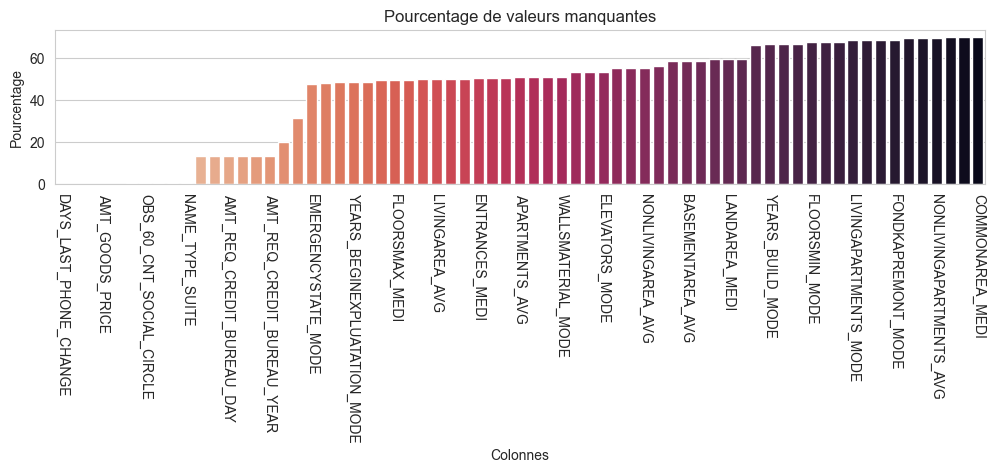

In [55]:
create_percentage_missing_chart(app_train[missing_columns], 3)

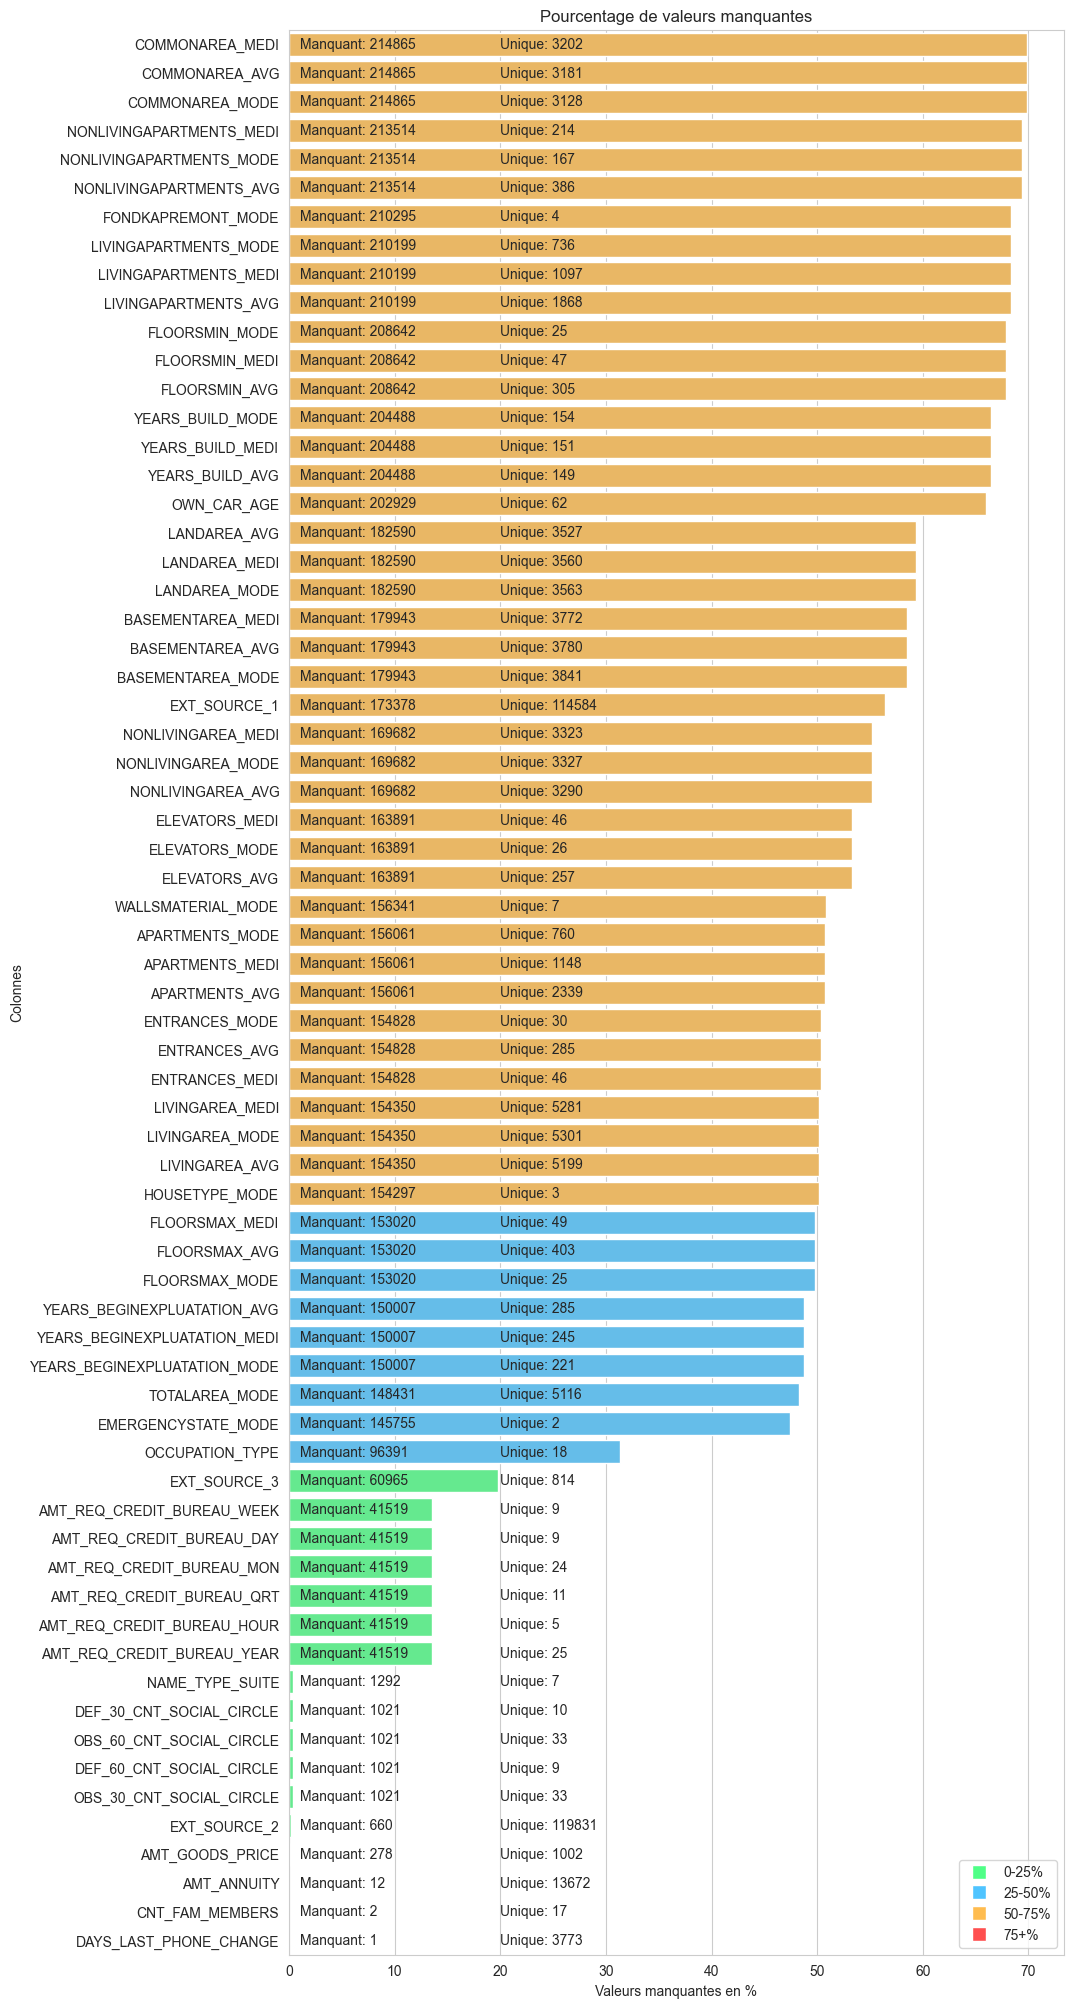

In [56]:
display_graph_missing_data(app_train[missing_columns], 25)

In [57]:
app_train.dtypes.value_counts()

float64    65
int64      40
object     15
Name: count, dtype: int64

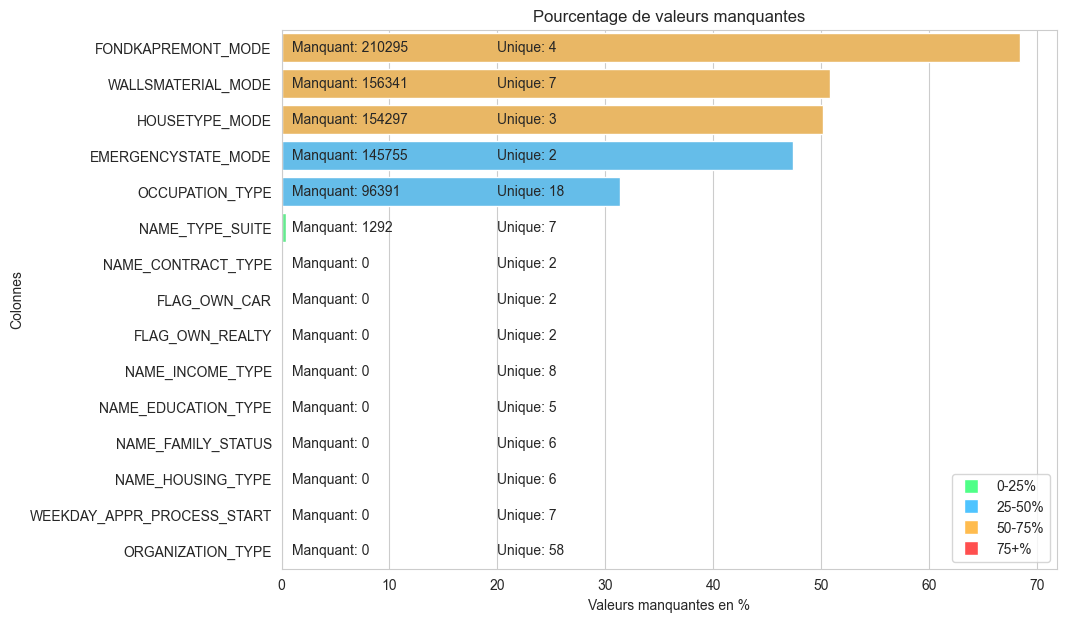

In [58]:
display_graph_missing_data(app_train.select_dtypes('object'), 7)

In [59]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # print(
        unique_vals = list(app_train[col].unique())
                 
        if len(unique_vals) <= 2.0:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col].map(lambda x: x if x in unique_vals else np.nan))
            app_test[col] = le.transform(app_test[col].map(lambda x: x if x in unique_vals else 0))
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)


3 columns were label encoded.


In [60]:
print('Training Features shape before: ', app_train.shape)
print('Testing Features shape before: ', app_test.shape)

# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('\nTraining Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape before:  (307511, 120)
Testing Features shape before:  (48744, 119)

Training Features shape:  (307511, 239)
Testing Features shape:  (48744, 236)


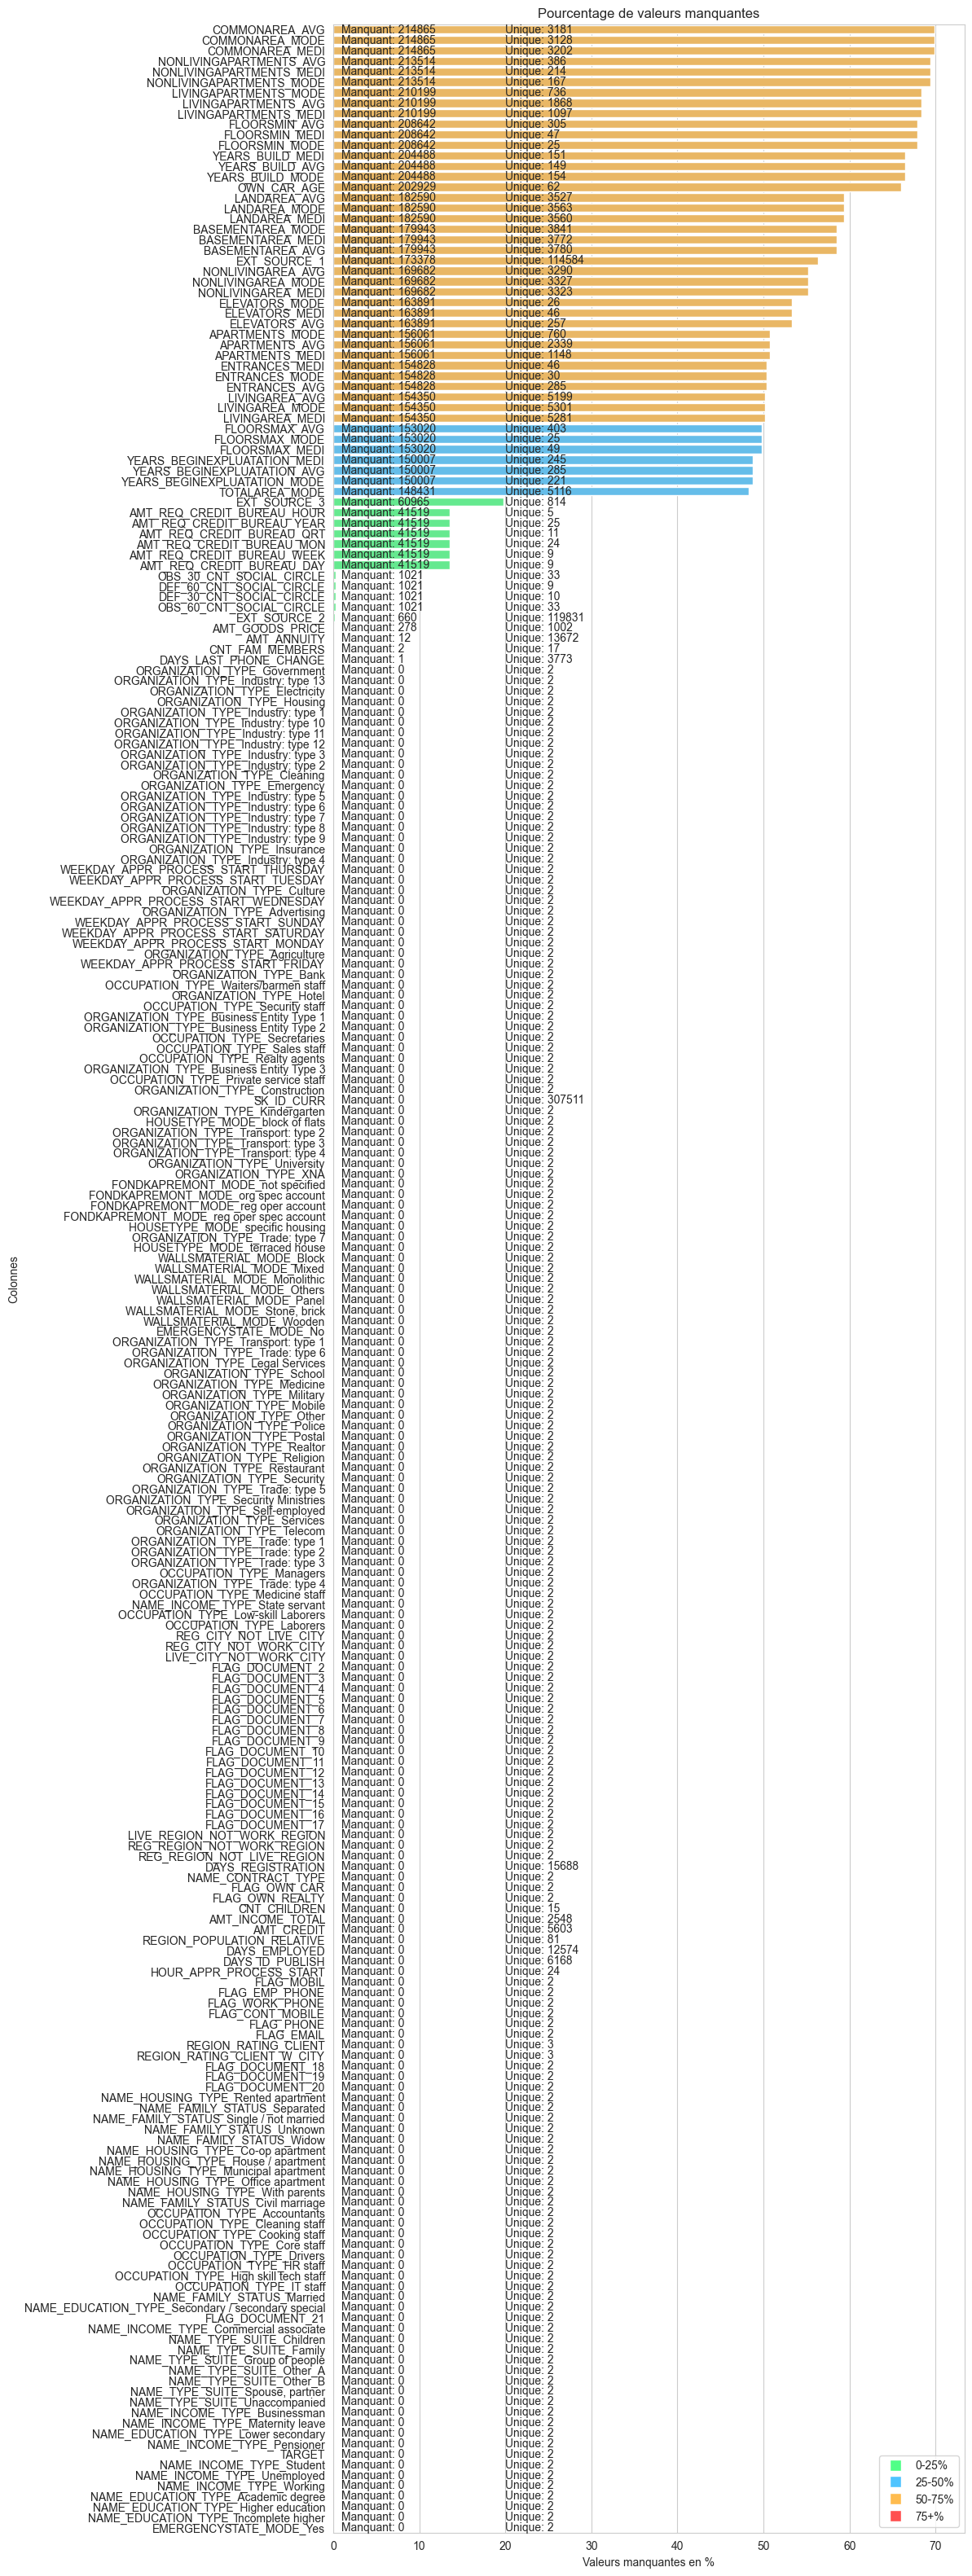

In [61]:
display_graph_missing_data(app_train, 40)

In [62]:
# app_train['DAYS_BIRTH'].describe()
# (app_train['DAYS_BIRTH'] / 365).describe()

In [63]:
X = clean_app_train.drop('TARGET', axis=1)  # Exclude the target column
y = clean_app_train['TARGET']

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(10420, 238)
(10420,)


In [64]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [65]:
# Draw the feature importance
feature_importances = rf_model.feature_importances_
# Assuming feature_importances is a list or array containing feature importances
threshold = 0.01  # Set your threshold based on your analysis

# Filter features based on the threshold
selected_features = [feature for feature, importance in zip(X.columns, feature_importances) if importance > threshold]

# Create a new feature matrix with selected features
X_selected = X[selected_features]

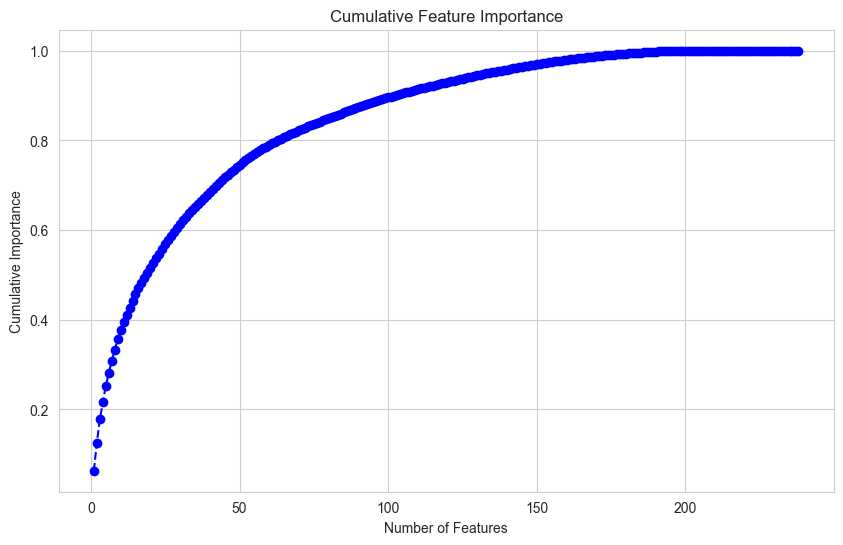

In [66]:
# Assuming feature_importances is a list or array containing feature importances
feature_importances = rf_model.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_idx]

# Calculate cumulative importance
cumulative_importance = np.cumsum(sorted_importances)

# Plot the cumulative importance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.grid(True)
plt.show()

In [67]:
# Looks like around 60 features could be used

In [68]:
selected_features

['SK_ID_CURR',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'LANDAREA_AVG',
 'LIVINGAREA_AVG',
 'COMMONAREA_MODE',
 'LANDAREA_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAREA_MODE',
 'COMMONAREA_MEDI',
 'LANDAREA_MEDI',
 'TOTALAREA_MODE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [69]:
app_train.shape

(307511, 239)

In [70]:
# Correlation V2 
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 LIVE_CITY_NOT_WORK_CITY                              0.032518
OWN_CAR_AGE                                          0.037612
DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [71]:
print(len(correlations[correlations > threshold]))
correlations[correlations > threshold]

35


ORGANIZATION_TYPE_Restaurant                         0.010266
NAME_EDUCATION_TYPE_Lower secondary                  0.011747
OCCUPATION_TYPE_Cooking staff                        0.012222
OCCUPATION_TYPE_Security staff                       0.014648
ORGANIZATION_TYPE_Transport: type 3                  0.017552
CNT_CHILDREN                                         0.019187
OCCUPATION_TYPE_Sales staff                          0.019537
NAME_HOUSING_TYPE_Rented apartment                   0.019767
ORGANIZATION_TYPE_Construction                       0.019792
AMT_REQ_CREDIT_BUREAU_YEAR                           0.019930
NAME_FAMILY_STATUS_Civil marriage                    0.022496
ORGANIZATION_TYPE_Business Entity Type 3             0.023993
NAME_FAMILY_STATUS_Single / not married              0.026518
OCCUPATION_TYPE_Low-skill Laborers                   0.027591
FLAG_WORK_PHONE                                      0.028524
ORGANIZATION_TYPE_Self-employed                      0.029139
NAME_HOU

In [72]:
test_corr = correlations[correlations > threshold].copy()
# Todo > Remove target accordingly
test_corr.drop(columns=["TARGET"], inplace=True)
# test_corr.sum()
test_corr.sum() - 1 # TMP


1.1213166797199303

In [73]:
test_corr

ORGANIZATION_TYPE_Restaurant                         0.010266
NAME_EDUCATION_TYPE_Lower secondary                  0.011747
OCCUPATION_TYPE_Cooking staff                        0.012222
OCCUPATION_TYPE_Security staff                       0.014648
ORGANIZATION_TYPE_Transport: type 3                  0.017552
CNT_CHILDREN                                         0.019187
OCCUPATION_TYPE_Sales staff                          0.019537
NAME_HOUSING_TYPE_Rented apartment                   0.019767
ORGANIZATION_TYPE_Construction                       0.019792
AMT_REQ_CREDIT_BUREAU_YEAR                           0.019930
NAME_FAMILY_STATUS_Civil marriage                    0.022496
ORGANIZATION_TYPE_Business Entity Type 3             0.023993
NAME_FAMILY_STATUS_Single / not married              0.026518
OCCUPATION_TYPE_Low-skill Laborers                   0.027591
FLAG_WORK_PHONE                                      0.028524
ORGANIZATION_TYPE_Self-employed                      0.029139
NAME_HOU

In [74]:
# Todo > Cumulative

In [75]:
# TODO >
# Features importances global
# Entraine un random forest avec toutes les cases, c'est mieux de les normaliser
# Excplication métier > Gain de temps en rendez-vous car moins de features.

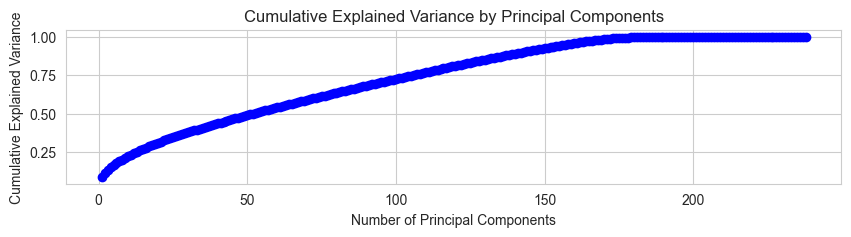

In [76]:
# Do A PCA for potential dimention reductiona
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming X is your feature matrix

# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Step 3: Plot the explained variance
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 2))
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [77]:
df_PCA = app_train.drop('TARGET', axis=1)
pcs = pca.components_
pcs = pd.DataFrame(pcs)
features = df_PCA.columns
pcs.columns = features
pcs.index = [f"F{i}" for i in range(1,239)]
pcs.round(2)
pcs.T

F1            F2            F3  \
SK_ID_CURR                      -2.398946e-03  6.733868e-03  9.390848e-04   
NAME_CONTRACT_TYPE               2.066524e-03  6.792920e-04 -4.557873e-02   
FLAG_OWN_CAR                     2.220446e-16  2.081668e-16 -4.649059e-16   
FLAG_OWN_REALTY                 -4.674955e-03  1.295882e-02 -2.652778e-02   
CNT_CHILDREN                    -1.069725e-03  4.826772e-03 -5.636444e-02   
...                                       ...           ...           ...   
WALLSMATERIAL_MODE_Panel         6.823587e-02  3.014720e-03 -7.210650e-02   
WALLSMATERIAL_MODE_Stone, brick -6.198226e-02  2.592808e-02  3.966196e-02   
WALLSMATERIAL_MODE_Wooden       -3.972058e-02  2.883315e-02  4.442913e-02   
EMERGENCYSTATE_MODE_No           2.636288e-02 -2.512509e-02 -5.008352e-02   
EMERGENCYSTATE_MODE_Yes         -2.636288e-02  2.512509e-02  5.008352e-02   

                                           F4            F5            F6  \
SK_ID_CURR                       1.360990e-02  7.797142e-03  2.169818e-03   
NAME_CONTRACT_TYPE               2.134871e-02  1.304401e-01 -6.230276e-03   
FLAG_OWN_CAR                     9.540979e-17  6.784395e-16 -8.153200e-17   
FLAG_OWN_REALTY                  5.222878e-03 -3.561382e-02  6.755878e-02   
CNT_CHILDREN                     4.222567e-02 -1.393189e-01  6.038698e-02   
...                                       ...           ...           ...   
WALLSMATERIAL_MODE_Panel        -1.888919e-01 -1.717088e-02  1.779975e-02   
WALLSMATERIAL_MODE_Stone, brick  1.368440e-01  6.580769e-05 -3.031443e-02   
WALLSMATERIAL_MODE_Wooden        3.482488e-02  3.320961e-02  4.190182e-02   
EMERGENCYSTATE_MODE_No          -3.298613e-02 -4.152078e-02 -5.246149e-02   
EMERGENCYSTATE_MODE_Yes          3.298613e-02  4.152078e-02  5.246149e-02   

                                           F7            F8            F9  \
SK_ID_CURR                       3.529201e-03 -8.142599e-04 -2.080804e-02   
NAME_CONTRACT_TYPE              -6.953152e-02 -1.860968e-01 -1.673634e-01   
FLAG_OWN_CAR                    -9.194034e-17 -4.946130e-16 -6.591949e-16   
FLAG_OWN_REALTY                 -4.029010e-03 -6.822492e-03 -1.026088e-01   
CNT_CHILDREN                     2.531708e-01 -2.287077e-01 -7.772879e-02   
...                                       ...           ...           ...   
WALLSMATERIAL_MODE_Panel        -8.389496e-03  6.410324e-03  3.931644e-02   
WALLSMATERIAL_MODE_Stone, brick -1.414091e-02 -5.791026e-03 -9.464696e-02   
WALLSMATERIAL_MODE_Wooden        6.692623e-02  1.513542e-02  1.927552e-01   
EMERGENCYSTATE_MODE_No          -8.093700e-02 -4.462417e-02 -2.903738e-01   
EMERGENCYSTATE_MODE_Yes          8.093700e-02  4.462417e-02  2.903738e-01   

                                          F10           F11           F12  \
SK_ID_CURR                       1.749099e-02  2.219569e-03  2.790144e-03   
NAME_CONTRACT_TYPE               4.390861e-02 -2.781623e-03  1.269292e-01   
FLAG_OWN_CAR                     1.422473e-16 -7.632783e-17  5.767956e-16   
FLAG_OWN_REALTY                 -2.949165e-02 -2.391613e-02  1.657430e-01   
CNT_CHILDREN                     5.989918e-02  9.237409e-02  7.146878e-02   
...                                       ...           ...           ...   
WALLSMATERIAL_MODE_Panel        -9.290982e-02  6.992506e-03  1.041719e-01   
WALLSMATERIAL_MODE_Stone, brick  1.380870e-03  7.762771e-03 -1.401208e-01   
WALLSMATERIAL_MODE_Wooden        2.048682e-01 -8.448421e-02  1.306274e-01   
EMERGENCYSTATE_MODE_No          -3.264152e-01  1.357520e-01 -2.443134e-01   
EMERGENCYSTATE_MODE_Yes          3.264152e-01 -1.357520e-01  2.443134e-01   

                                          F13           F14           F15  \
SK_ID_CURR                      -9.583726e-03 -5.671387e-03 -7.549547e-03   
NAME_CONTRACT_TYPE              -1.932491e-02 -6.900441e-02 -2.896053e-02   
FLAG_OWN_CAR                    -4.510281e-17 -3.747003e-16 -1.127570e-16   
FLAG_OWN_REALTY                 -8.

<Axes: >

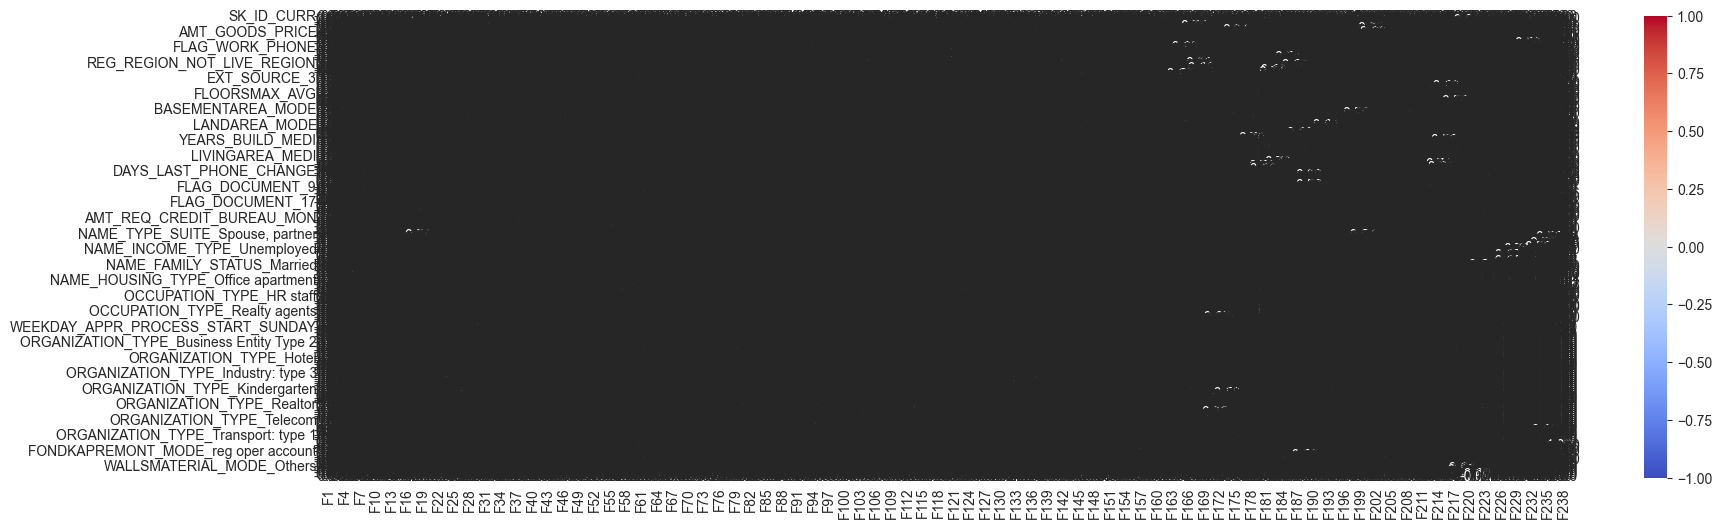

In [78]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

In [79]:
# Next steps:
# Clean the Notebook
# Finish with boxplot
# Get the 2 correlated algo (keep with 11k values)
# AFTER > (try to get more data than 11k, maybe some more columns can have 0 and update the notebook?)
# Prepare to continue the notebook with only those data
# Exploratory analysis on those columns from Kaggle
# Failure to repay depending on date of employment ?

In [80]:
app_train['DAYS_EMPLOYED'] = abs(app_train['DAYS_EMPLOYED'])
app_train['DAYS_EMPLOYED'].corr(app_train['TARGET'])

-0.04704582521599294

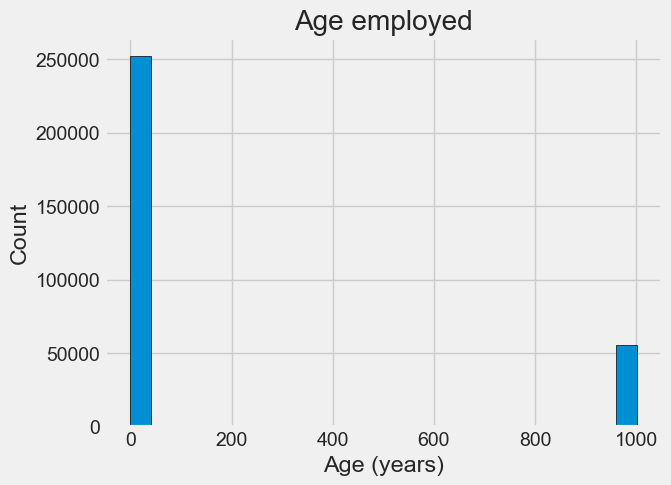

In [81]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
# plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
# plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

# Plot the distribution of ages in years
plt.hist(abs(app_train['DAYS_EMPLOYED']) / 365, edgecolor = 'k', bins = 25)
plt.title('Age employed'); plt.xlabel('Age (years)'); plt.ylabel('Count');

In [82]:
# Check outliers of all other columns
# Box plot of all columns

In [83]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_EMPLOYED']].copy()  
age_data.loc[:, 'YEARS_EMPLOYED'] = abs(age_data['DAYS_EMPLOYED']) / 365

# # Bin the age data

# age_data.loc[:, 'YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_EMPLOYED  YEARS_EMPLOYED
0       1            637        1.745205
1       0           1188        3.254795
2       0            225        0.616438
3       0           3039        8.326027
4       0           3038        8.323288
5       0           1588        4.350685
6       0           3130        8.575342
7       0            449        1.230137
8       0         365243     1000.665753
9       0           2019        5.531507

In [84]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

KeyError: 'YEARS_BINNED'

In [ ]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

In [ ]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_EMPLOYED'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_EMPLOYED'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); 
plt.ylabel('Density'); 
plt.title('Distribution of Ages');

In [ ]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

In [ ]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [ ]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [ ]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_EMPLOYED']).copy()

# Add in the age of the client in years
plot_data['YEARS_EMPLOYED'] = age_data['YEARS_EMPLOYED']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);